# 20133807 Jeong Seong Woon

In [230]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd

## Load data & Convert Image data to matrix for calculating

In [232]:
transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(),])
train_data_path = './horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False, num_workers=1)
validation_data_path = './horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=10, shuffle=False, num_workers=1)

train_data = []
train_label = []
val_data = []
val_label = []

for i, data in enumerate(trainloader):
    inputs, labels = data
    train_data_batch = []
    for j in range(len(inputs)):        
        image_temp = inputs[j][0].numpy()
        image = []
        for k in range(len(image_temp)):
            image_column = image_temp[:,k]
            image_column = image_column.reshape((100,1))
            if k==0:
                image = image_column
            else:
                image = np.vstack((image,image_column))
        if j == 0:
            train_data_batch = image
        else:
            train_data_batch = np.hstack((train_data_batch,image))
    if i == 0:
        train_data = train_data_batch
    else:
        train_data = np.hstack((train_data,train_data_batch))
    train_label = train_label+labels.tolist()
train_label = np.array(train_label)
train_label = train_label.reshape((len(train_label),1))

for i, data in enumerate(valloader):
    inputs, labels = data
    val_data_batch = []
    for j in range(len(inputs)):        
        image_temp = inputs[j][0].numpy()
        image = []
        for k in range(len(image_temp)):
            image_column = image_temp[:,k]
            image_column = image_column.reshape((100,1))
            if k==0:
                image = image_column
            else:
                image = np.vstack((image,image_column))
        if j == 0:
            val_data_batch = image
        else:
            val_data_batch = np.hstack((val_data_batch,image))
    if i == 0:
        val_data = val_data_batch
    else:
        val_data = np.hstack((val_data,val_data_batch))
    val_label = val_label+labels.tolist()
val_label = np.array(val_label)
val_label = val_label.reshape((len(val_label),1))

## Define Sigmoid function

In [233]:
def sigmoid(x):
    sig = 1/(1+np.exp(-x))
    return sig

## Define Loss function with Regularization

In [256]:
def lossFunc(label, h, w1, w2, w3, reg_rate):
    m = len(label)
    n = len(train_data)
    loss = (-1/m)*np.sum(label*np.log(sigmoid(h.T)) + (1-label)*np.log(1-sigmoid(h.T)))
    reg = (reg_rate/(2*n))*(np.sum(w1**2)+np.sum(w2**2)+np.sum(w3**2))
    return reg+loss

## Define Accuracy function

In [235]:
def accuracyFunc(h):
    return h.T >= 0.5

## Define Neural Netwokr Class with GradientDescent  through Vectorizing

In [288]:
loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []

class deepNetwork:
    def __init__(self, inputNode, hidden_1, hidden_2, learningrate, activation, reg_rate):
        self.inodes = inputNode
        self.h1 = hidden_1
        self.h2 = hidden_2

        self.lr = learningrate
        self.af = activation
        self.rr = reg_rate
        m = len(self.inodes[0]) #라벨개수
        #가중치
        np.random.seed(0)
        # 초기화
        self.w1 = np.random.normal(0.0, pow(self.h1, -0.5),(len(self.inodes), self.h1))
        self.w2 = np.random.normal(0.0, pow(self.h2, -0.5),(self.h1, self.h2))
        self.w3 = np.random.normal(0.0, pow(1, -0.5),(self.h2, 1))        
        
#         self.w1 = np.random.normal(size = (len(self.inodes), self.h1))
#         self.w2 = np.random.normal(size =(self.h1, self.h2))
#         self.w3 = np.random.normal(size =(self.h2, 1))
            
        self.b1 = 0.5
        self.b2 = 0.5
        self.b3 = 0.5
        
        self.b1_val = 0.5
        self.b2_val = 0.5
        self.b3_val = 0.5
    
    def train(self, label):
        iterations = 0
        m = len(label)
        loss_old = 0
        while(True):
            iterations+=1            
            z1 = np.dot(self.w1.T, self.inodes) + self.b1
            a1 = self.af(z1)

            z2 = np.dot(self.w2.T, a1) + self.b2
            a2 = self.af(z2) #(h2,1027)

            z3 = np.dot(self.w3.T, a2)+self.b3            
            a3 = self.af(z3) # 예측값 (1,1027)
                        
            
            z1_val = np.dot(self.w1.T, val_data)+self.b1_val
#             z1_val = np.dot(self.w1.T, val_data)
            a1_val = self.af(z1_val)

            z2_val = np.dot(self.w2.T, a1_val)+ self.b2_val
#             z2_val = np.dot(self.w2.T, a1_val)
            a2_val = self.af(z2_val) 

            z3_val = np.dot(self.w3.T, a2_val) +self.b3_val  
#             z3_val = np.dot(self.w3.T, a2_val) 
            a3_val = self.af(z3_val) 
            
            # 손실함수에 regularisation 추가
            loss = lossFunc(label, a3, self.w1, self.w2, self.w3, self.rr) 
            loss_val = lossFunc(val_label,a3_val,self.w1, self.w2, self.w3, self.rr)
            accuracy = (accuracyFunc(a3) == label).sum() / m
            accuracy_val=(accuracyFunc(a3_val) == val_label).sum() / len(val_label)
            
            if abs(loss_old-loss)< 1e-4:
                break

            loss_old = loss
            loss_list_train.append(loss_old)
            loss_list_val.append(loss_val)
            accuracy_list_train.append(accuracy)
            accuracy_list_val.append(accuracy_val)
            
            # 가중치 업데이트에 regularisation 추가
            #w3:(h2,1) / w2:(h1,h2) / w1:(10000,h1)
            w3_update = -label.T + a3  #(1,1027)
            w2_update = np.dot(w3_update.T, self.w3.T).T * (a2*(1-a2)) #(h2,1027) 
            w1_update = np.dot(w2_update.T, self.w2.T).T * (a1*(1-a1)) #(h1, 1027)
            
            w3_update_val = -val_label.T + a3_val  #(1,1027)
            w2_update_val = np.dot(w3_update_val.T, self.w3.T).T * (a2_val*(1-a2_val)) #(h2,1027) 
            w1_update_val = np.dot(w2_update_val.T, self.w2.T).T * (a1_val*(1-a1_val)) #(h1, 1027)

            self.w3 = (1-self.lr*self.rr/m)*self.w3 -(self.lr/m)*np.dot(w3_update, a2.T).T
            self.w2 = (1-self.lr*self.rr/m)*self.w2 -(self.lr/m)*np.dot(w2_update, a1.T).T
            self.w1 = (1-self.lr*self.rr/m)*self.w1 -(self.lr/m)*np.dot(w1_update, self.inodes.T).T
            
            self.b3 = (1-self.lr*self.rr/m)*self.b3 - (self.lr/m)*w3_update
            self.b2 = (1-self.lr*self.rr/m)*self.b2 - (self.lr/m)*w2_update
            self.b1 = (1-self.lr*self.rr/m)*self.b1 - (self.lr/m)*w1_update
            
            self.b3_val = (1-self.lr*self.rr/m)*self.b3_val - (self.lr/m)*w3_update_val
            self.b2_val = (1-self.lr*self.rr/m)*self.b2_val - (self.lr/m)*w2_update_val
            self.b1_val = (1-self.lr*self.rr/m)*self.b1_val - (self.lr/m)*w1_update_val

## Bias

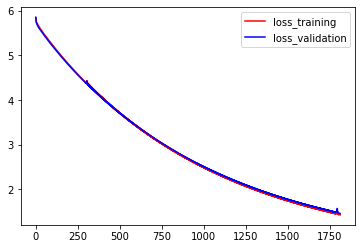

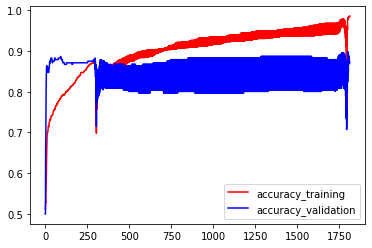

,Loss,Accruacy
Training,1.426733,0.985394
Validation,1.458685,0.871094


In [287]:
loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []
n = deepNetwork(train_data, 80, 20, 0.05, sigmoid, 10)
n.train(train_label)

plt.figure(1)
plt.plot(loss_list_train,label='loss_training',color= 'r')
plt.plot(loss_list_val,label='loss_validation',color = 'b')
plt.legend()

plt.figure(2)
plt.plot(accuracy_list_train,label='accuracy_training', color='r')
plt.plot(accuracy_list_val,label='accuracy_validation',color='b')
plt.legend()
plt.show()

data = [[loss_list_train[-1], accuracy_list_train[-1]],
        [loss_list_val[-1], accuracy_list_val[-1]]]
frame = pd.DataFrame(data, columns = ['Loss','Accruacy'],
                        index = ['Training','Validation'])
frame

## Variance

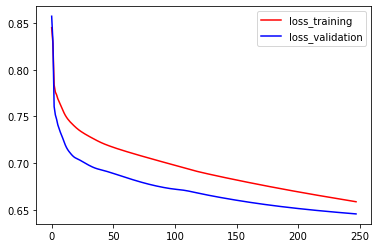

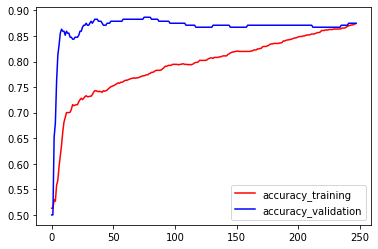

,Loss,Accruacy
Training,0.658731,0.874391
Validation,0.645698,0.875000


In [285]:
loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []
n = deepNetwork(train_data, 80, 20, 0.05, sigmoid, 0.1)
n.train(train_label)

plt.figure(1)
plt.plot(loss_list_train,label='loss_training',color= 'r')
plt.plot(loss_list_val,label='loss_validation',color = 'b')
plt.legend()

plt.figure(2)
plt.plot(accuracy_list_train,label='accuracy_training', color='r')
plt.plot(accuracy_list_val,label='accuracy_validation',color='b')
plt.legend()
plt.show()

data = [[loss_list_train[-1], accuracy_list_train[-1]],
        [loss_list_val[-1], accuracy_list_val[-1]]]
frame = pd.DataFrame(data, columns = ['Loss','Accruacy'],
                        index = ['Training','Validation'])
frame

## Best Generalization

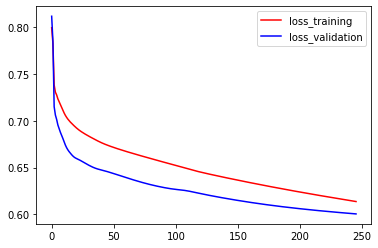

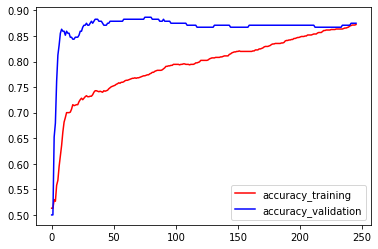

,Loss,Accruacy
Training,0.613788,0.872444
Validation,0.600563,0.875000


In [289]:
loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []
n = deepNetwork(train_data, 80, 20, 0.05, sigmoid, 0.01)
n.train(train_label)

plt.figure(1)
plt.plot(loss_list_train,label='loss_training',color= 'r')
plt.plot(loss_list_val,label='loss_validation',color = 'b')
plt.legend()

plt.figure(2)
plt.plot(accuracy_list_train,label='accuracy_training', color='r')
plt.plot(accuracy_list_val,label='accuracy_validation',color='b')
plt.legend()
plt.show()

data = [[loss_list_train[-1], accuracy_list_train[-1]],
        [loss_list_val[-1], accuracy_list_val[-1]]]
frame = pd.DataFrame(data, columns = ['Loss','Accruacy'],
                        index = ['Training','Validation'])
frame